In [3]:
# Imports
from __future__ import division
from __future__ import print_function

import argparse
from datetime import datetime
import json
import os
import sys
import time

import tensorflow as tf
import numpy as np
from tensorflow.python.client import timeline


/home/aeatda/anaconda3/envs/proj3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [1]:
SAMPLE_SIZE = 3600

In [2]:
wavenet_params = {
    "filter_width": 2,
    "sample_rate": 22050,
    "dilations": [1, 2, 4, 8, 16, 32, 64, 128, 256, 512,
                  1, 2, 4, 8, 16, 32, 64, 128, 256, 512],
    "residual_channels": 16,
    "dilation_channels": 16,
    "quantization_channels": 256,
    "skip_channels": 16,
    "use_biases": True,
    "scalar_input": False,
    "initial_filter_width": 32
}

for key in wavenet_params.keys():
    exec('{} = wavenet_params[\'{}\']'.format(key, key))
    print('{:21}'.format(key), eval(key))

filter_width          2
sample_rate           22050
dilations             [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
residual_channels     16
dilation_channels     16
quantization_channels 256
skip_channels         16
use_biases            True
scalar_input          False
initial_filter_width  32


In [4]:
# Helper functions for WaveNetModel class

def create_variable(name, shape):
    '''Create a convolution filter variable with the specified name and shape,
    and initialize it using Xavier initialition.'''
    initializer = tf.contrib.layers.xavier_initializer_conv2d()
    variable = tf.Variable(initializer(shape=shape), name=name)
    return variable


def create_embedding_table(name, shape):
    if shape[0] == shape[1]:
        # Make a one-hot encoding as the initial value.
        initial_val = np.identity(n=shape[0], dtype=np.float32)
        return tf.Variable(initial_val, name=name)
    else:
        return create_variable(name, shape)


def create_bias_variable(name, shape):
    '''Create a bias variable with the specified name and shape and initialize
    it to zero.'''
    initializer = tf.constant_initializer(value=0.0, dtype=tf.float32)
    return tf.Variable(initializer(shape=shape), name)

In [5]:
# time_to_batch, batch_to_time, causal_conv

def time_to_batch(value, dilation, name=None):
    with tf.name_scope('time_to_batch'):
        shape = tf.shape(value)
        pad_elements = dilation - 1 - (shape[1] + dilation - 1) % dilation
        padded = tf.pad(value, [[0, 0], [0, pad_elements], [0, 0]])
        reshaped = tf.reshape(padded, [-1, dilation, shape[2]])
        transposed = tf.transpose(reshaped, perm=[1, 0, 2])
        return tf.reshape(transposed, [shape[0] * dilation, -1, shape[2]])


def batch_to_time(value, dilation, name=None):
    with tf.name_scope('batch_to_time'):
        shape = tf.shape(value)
        prepared = tf.reshape(value, [dilation, -1, shape[2]])
        transposed = tf.transpose(prepared, perm=[1, 0, 2])
        return tf.reshape(transposed,
                          [tf.div(shape[0], dilation), -1, shape[2]])


def causal_conv(value, filter_, dilation, name='causal_conv'):
    with tf.name_scope(name):
        filter_width = tf.shape(filter_)[0]
        if dilation > 1:
            transformed = time_to_batch(value, dilation)
            conv = tf.nn.conv1d(transformed, filter_, stride=1,
                                padding='VALID')
            restored = batch_to_time(conv, dilation)
        else:
            restored = tf.nn.conv1d(value, filter_, stride=1, padding='VALID')
        # Remove excess elements at the end.
        out_width = tf.shape(value)[1] - (filter_width - 1) * dilation
        result = tf.slice(restored,
                          [0, 0, 0],
                          [-1, out_width, -1])
        return result


In [91]:
## scalar_input option does not work now

class WaveNetModel(object):
    '''WaveNet model modified for binary classification.
    Modified by John Choi (isnbh0)

    Default parameters:
        dilations = [2**i for i in range(10)] * 2
        filter_width = 2  # Convolutions just use 2 samples.
        residual_channels = 16  # Not specified in the paper.
        dilation_channels = 16  # Not specified in the paper.
        skip_channels = 16      # Not specified in the paper.
        net = WaveNetModel(batch_size, dilations, filter_width,
                           residual_channels, dilation_channels,
                           skip_channels)
        loss = net.loss(input_batch)
    '''

    def __init__(self,
                 batch_size,
                 dilations,
                 filter_width,
                 residual_channels,
                 dilation_channels,
                 skip_channels,
                 quantization_channels=2**8,
                 use_biases=False,
                 scalar_input=False,
                 initial_filter_width=32,
                 histograms=False):
        '''Initializes the WaveNet model.

        Args:
            batch_size: audio files per batch (recommended: 1).
            dilations: A list with the dilation factor for each layer.
            filter_width: The samples that are included in each convolution,
                after dilating.
            residual_channels: # filters to learn for the residual.
            dilation_channels: # filters to learn for the dilated convolution.
            skip_channels: # filters to learn that contribute to the
                quantized softmax output.
            quantization_channels: # amplitude values to use for audio
                quantization and the corresponding one-hot encoding.
                Default: 256 (8-bit quantization).
            use_biases: Whether to add a bias layer to each convolution.
                Default: False.
            scalar_input: Whether to use the quantized waveform directly as
            |   input to the network instead of one-hot encoding it.
            |   Default: False.
            *-initial_filter_width: The width of the initial filter of the
                convolution applied to the scalar input. This is only relevant
                if scalar_input=True.
            histograms: Whether to store histograms in the summary.
                Default: False.


        '''
        self.batch_size = batch_size
        self.dilations = dilations
        self.filter_width = filter_width
        self.residual_channels = residual_channels
        self.dilation_channels = dilation_channels
        self.quantization_channels = quantization_channels
        self.use_biases = use_biases
        self.skip_channels = skip_channels
        self.scalar_input = scalar_input
        self.initial_filter_width = initial_filter_width
        self.histograms = histograms

        self.receptive_field = WaveNetModel.calculate_receptive_field(
            self.filter_width, self.dilations, self.scalar_input,
            self.initial_filter_width)
        self.variables = self._create_variables()

    @staticmethod
    def calculate_receptive_field(filter_width, dilations, scalar_input,
                                  initial_filter_width):
        receptive_field = (filter_width - 1) * sum(dilations) + 1
        if scalar_input:
            receptive_field += initial_filter_width - 1
        else:
            receptive_field += filter_width - 1
        return receptive_field

    def _create_variables(self):
        '''This function creates all variables used by the network.
        This allows us to share them between multiple calls to the loss
        function and generation function.'''

        var = dict()

        with tf.variable_scope('wavenet'):
            with tf.variable_scope('causal_layer'):
                layer = dict()
                if self.scalar_input:
                    initial_channels = 1
                    initial_filter_width = self.initial_filter_width
                else:
                    initial_channels = self.quantization_channels
                    initial_filter_width = self.filter_width
                layer['filter'] = create_variable(
                    'filter',
                    [initial_filter_width,
                     initial_channels,
                     self.residual_channels])
                var['causal_layer'] = layer

            var['dilated_stack'] = list()
            with tf.variable_scope('dilated_stack'):
                for i, dilation in enumerate(self.dilations):
                    with tf.variable_scope('layer{}'.format(i)):
                        current = dict()
                        current['filter'] = create_variable(
                            'filter',
                            [self.filter_width,
                             self.residual_channels,
                             self.dilation_channels])
                        current['gate'] = create_variable(
                            'gate',
                            [self.filter_width,
                             self.residual_channels,
                             self.dilation_channels])
                        current['dense'] = create_variable(
                            'dense',
                            [1,
                             self.dilation_channels,
                             self.residual_channels])
                        current['skip'] = create_variable(
                            'skip',
                            [1,
                             self.dilation_channels,
                             self.skip_channels])



                        if self.use_biases:
                            current['filter_bias'] = create_bias_variable(
                                'filter_bias',
                                [self.dilation_channels])
                            current['gate_bias'] = create_bias_variable(
                                'gate_bias',
                                [self.dilation_channels])
                            current['dense_bias'] = create_bias_variable(
                                'dense_bias',
                                [self.residual_channels])
                            current['skip_bias'] = create_bias_variable(
                                'slip_bias',
                                [self.skip_channels])

                        var['dilated_stack'].append(current)

            with tf.variable_scope('postprocessing'):
                current = dict()
                current['postprocess1'] = create_variable(
                    'postprocess1',
                    [1, self.skip_channels, self.skip_channels])
                current['postprocess2'] = create_variable(
                    'postprocess2',
                    [1, self.skip_channels, 1])  ## returns scalar value
                if self.use_biases:
                    current['postprocess1_bias'] = create_bias_variable(
                        'postprocess1_bias',
                        [self.skip_channels])
                    current['postprocess2_bias'] = create_bias_variable(
                        'postprocess2_bias',
                        [1])
                var['postprocessing'] = current

        return var

    def _create_causal_layer(self, input_batch):
        '''Creates a single causal convolution layer.

        The layer can change the number of channels.
        '''
        with tf.name_scope('causal_layer'):
            weights_filter = self.variables['causal_layer']['filter']
            return causal_conv(input_batch, weights_filter, 1)

    def _create_dilation_layer(self, input_batch, layer_index, dilation,
                               output_width):
        '''Creates a single causal dilated convolution layer.

        Args:
             input_batch: Input to the dilation layer.
             layer_index: Integer indicating which layer this is.
             dilation: Integer specifying the dilation size.

        The layer contains a gated filter that connects to dense output
        and to a skip connection:

               |-> [gate]   -|        |-> 1x1 conv -> skip output
               |             |-> (*) -|
        input -|-> [filter] -|        |-> 1x1 conv -|
               |                                    |-> (+) -> dense output
               |------------------------------------|

        Where `[gate]` and `[filter]` are causal convolutions with a
        non-linear activation at the output. Biases and global conditioning
        are omitted due to the limits of ASCII art.

        '''
        variables = self.variables['dilated_stack'][layer_index]

        weights_filter = variables['filter']
        weights_gate = variables['gate']

        conv_filter = causal_conv(input_batch, weights_filter, dilation)
        conv_gate = causal_conv(input_batch, weights_gate, dilation)


        if self.use_biases:
            filter_bias = variables['filter_bias']
            gate_bias = variables['gate_bias']
            conv_filter = tf.add(conv_filter, filter_bias)
            conv_gate = tf.add(conv_gate, gate_bias)

        out = tf.tanh(conv_filter) * tf.sigmoid(conv_gate)

        # The 1x1 conv to produce the residual output
        weights_dense = variables['dense']
        transformed = tf.nn.conv1d(
            out, weights_dense, stride=1, padding="SAME", name="dense")

        # The 1x1 conv to produce the skip output
        skip_cut = tf.shape(out)[1] - output_width
        out_skip = tf.slice(out, [0, skip_cut, 0], [-1, -1, -1])
        weights_skip = variables['skip']
        skip_contribution = tf.nn.conv1d(
            out_skip, weights_skip, stride=1, padding="SAME", name="skip")

        if self.use_biases:
            dense_bias = variables['dense_bias']
            skip_bias = variables['skip_bias']
            transformed = transformed + dense_bias
            skip_contribution = skip_contribution + skip_bias

        if self.histograms:
            layer = 'layer{}'.format(layer_index)
            tf.summary.histogram(layer + '_filter', weights_filter)
            tf.summary.histogram(layer + '_gate', weights_gate)
            tf.summary.histogram(layer + '_dense', weights_dense)
            tf.summary.histogram(layer + '_skip', weights_skip)
            if self.use_biases:
                tf.summary.histogram(layer + '_biases_filter', filter_bias)
                tf.summary.histogram(layer + '_biases_gate', gate_bias)
                tf.summary.histogram(layer + '_biases_dense', dense_bias)
                tf.summary.histogram(layer + '_biases_skip', skip_bias)

        input_cut = tf.shape(input_batch)[1] - tf.shape(transformed)[1]
        input_batch = tf.slice(input_batch, [0, input_cut, 0], [-1, -1, -1])

        return skip_contribution, input_batch + transformed

    def _generator_conv(self, input_batch, state_batch, weights):
        '''Perform convolution for a single convolutional processing step.'''
        # TODO generalize to filter_width > 2
        past_weights = weights[0, :, :]
        curr_weights = weights[1, :, :]
        output = tf.matmul(state_batch, past_weights) + tf.matmul(
            input_batch, curr_weights)
        return output

    def _generator_causal_layer(self, input_batch, state_batch):
        with tf.name_scope('causal_layer'):
            weights_filter = self.variables['causal_layer']['filter']
            output = self._generator_conv(
                input_batch, state_batch, weights_filter)
        return output

    def _generator_dilation_layer(self, input_batch, state_batch, layer_index,
                                  dilation):
        variables = self.variables['dilated_stack'][layer_index]

        weights_filter = variables['filter']
        weights_gate = variables['gate']
        output_filter = self._generator_conv(
            input_batch, state_batch, weights_filter)
        output_gate = self._generator_conv(
            input_batch, state_batch, weights_gate)

        if self.use_biases:
            output_filter = output_filter + variables['filter_bias']
            output_gate = output_gate + variables['gate_bias']

        out = tf.tanh(output_filter) * tf.sigmoid(output_gate)

        weights_dense = variables['dense']
        transformed = tf.matmul(out, weights_dense[0, :, :])
        if self.use_biases:
            transformed = transformed + variables['dense_bias']

        weights_skip = variables['skip']
        skip_contribution = tf.matmul(out, weights_skip[0, :, :])
        if self.use_biases:
            skip_contribution = skip_contribution + variables['skip_bias']

        return skip_contribution, input_batch + transformed

    def _create_network(self, input_batch):
        '''Construct the WaveNet network.'''
        outputs = []
        current_layer = input_batch

        # Pre-process the input with a regular convolution
        if self.scalar_input:
            initial_channels = 1
        else:
            initial_channels = self.quantization_channels

        current_layer = self._create_causal_layer(current_layer)

        output_width = tf.shape(input_batch)[1] - self.receptive_field + 1

        # Add all defined dilation layers.
        with tf.name_scope('dilated_stack'):
            for layer_index, dilation in enumerate(self.dilations):
                with tf.name_scope('layer{}'.format(layer_index)):
                    output, current_layer = self._create_dilation_layer(
                        current_layer, layer_index, dilation,
                        output_width)
                    outputs.append(output)

        with tf.name_scope('postprocessing'):
            # Perform (+) -> ReLU -> 1x1 conv -> ReLU -> 1x1 conv to
            # postprocess the output.
            w1 = self.variables['postprocessing']['postprocess1']
            w2 = self.variables['postprocessing']['postprocess2']
            if self.use_biases:
                b1 = self.variables['postprocessing']['postprocess1_bias']
                b2 = self.variables['postprocessing']['postprocess2_bias']

            if self.histograms:
                tf.summary.histogram('postprocess1_weights', w1)
                tf.summary.histogram('postprocess2_weights', w2)
                if self.use_biases:
                    tf.summary.histogram('postprocess1_biases', b1)
                    tf.summary.histogram('postprocess2_biases', b2)

            # We skip connections from the outputs of each layer, adding them
            # all up here.
            total = sum(outputs)
            transformed1 = tf.nn.relu(total)
            conv1 = tf.nn.conv1d(transformed1, w1, stride=1, padding="SAME")
            if self.use_biases:
                conv1 = tf.add(conv1, b1)
            transformed2 = tf.nn.relu(conv1)
            conv2 = tf.nn.conv1d(transformed2, w2, stride=1, padding="SAME")
            if self.use_biases:
                conv2 = tf.add(conv2, b2)

            ## ADDED CODE HERE. ******************************
            ## RELU activation before going to dense node
            transformed3 = tf.nn.relu(conv2)

            ## Reshape to 2-D tensor with dimensions
            ## batch_size, sample_size
            ## shape[1] constant here so we can use dense
            shape = [tf.shape(transformed3)[0], SAMPLE_SIZE - sum(dilations) - 1]
            transformed3 = tf.reshape(transformed3, shape)
            
            ## Add dense layer to transform from
            ## batch_size x sample_size 2-D array to
            ## batch_size 1-D array
            final = tf.layers.dense(transformed3, units=1, reuse=tf.AUTO_REUSE,
                                    name='final_out')
        return final

    def _one_hot(self, input_batch, batch_size=None):
        '''One-hot encodes the waveform amplitudes.

        This allows the definition of the network as a categorical distribution
        over a finite set of possible amplitudes.
        '''
        if not batch_size:
            batch_size = self.batch_size
            
        with tf.name_scope('one_hot_encode'):
            encoded = tf.one_hot(
                input_batch,
                depth=self.quantization_channels,
                dtype=tf.float32)
            shape = [batch_size, -1, self.quantization_channels]
            encoded = tf.reshape(encoded, shape)
        return encoded

    def predict_proba(self, waveform, name='wavenet'):
        '''Computes the probability of waveform being LAUGHTER.
           Necessary for evaluation with test data.'''
        ## TODO
        ## tf.losses.sigmoid_cross_entropy(y_, train_out)
        with tf.name_scope(name):
            ## slice off rightmost end of input where labels are stored
            ## input_batch transformed into input_audio
            input_audio = tf.slice(waveform, begin=[0, 0, 0], size=[-1, SAMPLE_SIZE, -1])
            input_label = tf.slice(waveform, begin=[0, SAMPLE_SIZE, 0], size=[-1, 1, -1])
            
            input_audio = tf.to_int32(input_audio)


        with tf.name_scope(name):
            if self.scalar_input:
                encoded = tf.cast(waveform, tf.float32)
                encoded = tf.reshape(encoded, [-1, 1])
            else:
                encoded = self._one_hot(input_audio,
                                       batch_size=1)  # arg changed from waveform

            raw_output = self._create_network(encoded)
            raw_output = tf.reshape(raw_output, [-1])
            out = tf.nn.sigmoid(raw_output)

            return out

        
    def loss(self,
             input_batch,
             input_label=None,
             name='wavenet'):
        print(input_batch.shape)
        '''Creates a WaveNet network and returns crossentropy loss.

        The variables are all scoped to the given name.
        '''
## tf.losses.sigmoid_cross_entropy(y_, train_out)
        with tf.name_scope(name):
            if input_label is None:
                ## slice off rightmost end of input where labels are stored
                ## input_batch transformed into input_audio
                y_idx = tf.shape(input_batch)[1] - 1
                input_audio = tf.slice(input_batch, begin=[0, 0, 0], size=[-1, SAMPLE_SIZE, -1])
                input_label = tf.slice(input_batch, begin=[0, SAMPLE_SIZE, 0], size=[-1, 1, -1])
            else:
                input_audio = input_batch
                input_label = tf.reshape(input_label, [-1, 1, 1])
            ## mu-law encode disabled because using preprocessed data
            # encoded_input = mu_law_encode(input_batch,
            #                             self.quantization_channels)
            input_audio = tf.to_int32(input_audio)
            encoded = self._one_hot(input_audio)  # arg changed from encoded_input
            if self.scalar_input:
                network_input = tf.reshape(
                    tf.cast(input_batch, tf.float32),
                    [self.batch_size, -1, 1])
            else:
                network_input = encoded

              ## omitted for classification use
#             # Cut off the last sample of network input to preserve causality.
#             network_input_width = tf.shape(network_input)[1] - 1
#             network_input = tf.slice(network_input, [0, 0, 0],
#                                      [-1, network_input_width, -1])

            ## shape of raw_output is (batch_size, 1)
            raw_output = self._create_network(network_input)

            with tf.name_scope('loss'):
                ## format the target values
                target_output = tf.reshape(input_label, [self.batch_size])
                ## logits
                prediction = tf.reshape(raw_output, [self.batch_size])
             
                loss = tf.nn.sigmoid_cross_entropy_with_logits(
                    logits=prediction,
                    labels=target_output)
                reduced_loss = tf.reduce_mean(loss)

                tf.summary.scalar('loss', reduced_loss)

                return reduced_loss

## functions to read from TFRecord

In [92]:
data_path0 = '../_data/tfrecords/sample_3600_{}.tfrecord'

def parser(serialized_example):
    features = {
        'samples': tf.FixedLenFeature([SAMPLE_SIZE], tf.float32),
        'laugh' : tf.FixedLenFeature([1], tf.float32)
    }
    parsed_feature = tf.parse_single_example(serialized_example, features)
    samples = parsed_feature['samples']
    laugh = parsed_feature['laugh']
    return samples, laugh

def get_tfrecord(name='train', batch_size=1, buffer_size=5000,
                 repeat=1, seed=None):
    dataset = tf.data.TFRecordDataset(data_path0.format(name)).map(parser)
    dataset = dataset.batch(batch_size)
    dataset = dataset.shuffle(buffer_size, seed=seed)
    dataset = dataset.repeat(repeat)
    return dataset

# modeling with TFRecord

In [12]:
tf.reset_default_graph()

batch_size = 40
learning_rate = 1e-3
momentum = 0.9


data_train = get_tfrecord(batch_size=batch_size, seed=0)
itr = data_train.make_one_shot_iterator()
sample_batch, laugh = itr.get_next()
sample_batch = tf.reshape(sample_batch, [-1, sample_batch.shape[1], 1])


net = WaveNetModel(batch_size=batch_size, dilations=dilations, filter_width=filter_width,
                   residual_channels=residual_channels, dilation_channels=dilation_channels,
                   skip_channels=skip_channels,
                   histograms=True)
loss = net.loss(sample_batch, laugh)

In [13]:
optimizer = tf.train.MomentumOptimizer(learning_rate=1e-3,
                                       momentum=0.9)
trainable = tf.trainable_variables()
optim = optimizer.minimize(loss, var_list=trainable)

In [14]:
writer = tf.summary.FileWriter('./tf_logs/train/{}'
                        .format(datetime.now().strftime("%y%m%d_%H%M%S")))
writer.add_graph(tf.get_default_graph())
run_metadata = tf.RunMetadata()
summaries = tf.summary.merge_all()

In [15]:
# Set up session
sess = tf.Session(config=tf.ConfigProto(log_device_placement=False))
init = tf.global_variables_initializer()
sess.run(init)

# saver code not used

In [16]:
%%time

for step in range(5):
    summ_, loss_, _ = sess.run([summaries, loss, optim])
    writer.add_summary(summ_, step)
    print("step {:3}:  loss = {:8.6f}".format(step+1, loss_))

step   1:  loss = 0.703997
step   2:  loss = 0.703277
step   3:  loss = 0.714067
step   4:  loss = 0.697854
step   5:  loss = 0.675399
CPU times: user 1min 26s, sys: 3.42 s, total: 1min 30s
Wall time: 14.5 s


In [17]:
sess.close()

# validation loss implementation
* sigmoid cross entropy

In [20]:
pred = net.predict_proba(batch_test_tensor)

init = tf.global_variables_initializer()
sess.run(init)
pred_ = sess.run(pred)

(1, 3600, 256)


In [121]:
tf.reset_default_graph()

batch_size = 40
learning_rate = 1e-3
momentum = 0.9


data_train = get_tfrecord(name='train',
                          batch_size=batch_size,
                          seed=0,
                          repeat=1000)
data_test  = get_tfrecord(name='test',
                          batch_size=batch_size,
                          seed=0,
                          repeat=None)

train_itr = data_train.make_one_shot_iterator()
test_itr = data_test.make_one_shot_iterator()

train_batch, train_label = train_itr.get_next()
test_batch, test_label = test_itr.get_next()

train_batch = tf.reshape(train_batch, [-1, train_batch.shape[1], 1])
test_batch = tf.reshape(test_batch, [-1, test_batch.shape[1], 1])


net = WaveNetModel(batch_size=batch_size, dilations=dilations, filter_width=filter_width,
                   residual_channels=residual_channels, dilation_channels=dilation_channels,
                   skip_channels=skip_channels,
                   histograms=True)

train_loss = net.loss(train_batch, train_label)
test_loss = net.loss(test_batch, test_label)

(?, 3600, 1)
(?, 3600, 1)


In [122]:
test_batch.shape[1] + 1

Dimension(3601)

In [123]:
sess = tf.Session()

In [124]:
# t = sess.run(test_batch)
# t.shape, t

In [125]:
optimizer = tf.train.MomentumOptimizer(learning_rate=1e-3,
                                       momentum=0.9)
trainable = tf.trainable_variables()
optim = optimizer.minimize(train_loss, var_list=trainable)

In [126]:
writer = tf.summary.FileWriter('./tf_logs/train/{}'
                        .format(datetime.now().strftime("%y%m%d_%H%M%S")))
writer.add_graph(tf.get_default_graph())
run_metadata = tf.RunMetadata()
summaries = tf.summary.merge_all()

In [127]:
# Set up session
sess = tf.Session(config=tf.ConfigProto(log_device_placement=False))
init = tf.global_variables_initializer()
sess.run(init)

# saver code not used

In [128]:
%%time

trainloss = []
testloss = []

for step in range(100):
    summ_, train_loss_, test_loss_, _\
    = sess.run([summaries, train_loss,
                            test_loss, optim])
    writer.add_summary(summ_, step)
    print("step {:3}:  trainloss = {:8.7f},\
    testloss = {:8.7f}".format(step+1, train_loss_, test_loss_))
    
    trainloss.append(train_loss_)
    testloss.append(test_loss_)

step   1:  trainloss = 0.6878653,    testloss = 0.7002503
step   2:  trainloss = 0.6952513,    testloss = 0.6966518
step   3:  trainloss = 0.6915706,    testloss = 0.6966246
step   4:  trainloss = 0.6989090,    testloss = 0.7001393
step   5:  trainloss = 0.6970367,    testloss = 0.6965159
step   6:  trainloss = 0.6947023,    testloss = 0.6999785
step   7:  trainloss = 0.6945472,    testloss = 0.6998684
step   8:  trainloss = 0.6919483,    testloss = 0.6962833
step   9:  trainloss = 0.6847156,    testloss = 0.6961141
step  10:  trainloss = 0.6880020,    testloss = 0.6994189
step  11:  trainloss = 0.6927933,    testloss = 0.6994275
step  12:  trainloss = 0.6888224,    testloss = 0.6959215
step  13:  trainloss = 0.6926991,    testloss = 0.6958141
step  14:  trainloss = 0.6918344,    testloss = 0.6989541
step  15:  trainloss = 0.6881835,    testloss = 0.6988241
step  16:  trainloss = 0.6892937,    testloss = 0.6955166
step  17:  trainloss = 0.6941906,    testloss = 0.6986026
step  18:  tra

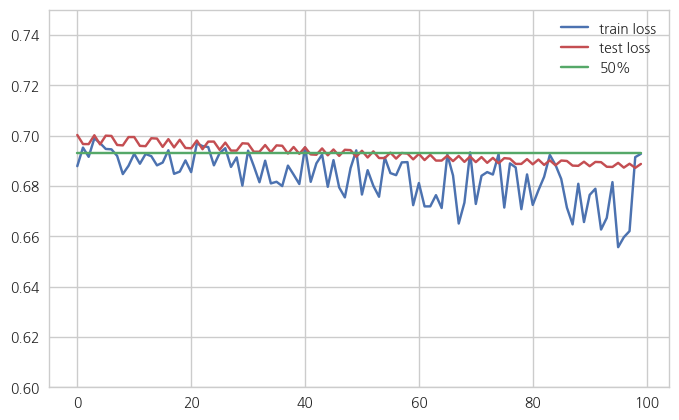

In [142]:
plt.plot(trainloss, 'b-', label='train loss')
plt.plot(testloss, 'r-', label='test loss')

plt.plot(np.ones(100)*np.log(2), 'g-', label='50%')

plt.ylim([0.6, 0.75])
plt.legend()
plt.show()

In [143]:
sess.close()